In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score,f1_score
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install tensorflow
!pip install scikit-learn
!pip install pandas
!pip install numpy

In [3]:
#### cleaning data
def pre_process(data_train):
  #### first we fill empty entries
  data = data_train.drop("patient_id",axis=1) # drop the id column, doesn't provide any predictive value
  data = data.fillna(data.select_dtypes(include='float').mean().round(1)) # fill for float values the mean

  for col in data.select_dtypes(include=['object']):  #for categorical data, empty entries are replaced by most occuring class in the column
    most_frequent = data[col].mode()[0]
    data[col].fillna(most_frequent, inplace=True)

  #### now we encode categorical, we take case by case
  cellularity_mapping = {
    'Low': 1,
    'Moderate': 2,
    'High': 3
  }
  data['cellularity'] = data['cellularity'].map(cellularity_mapping)

  encode = LabelEncoder()

  data['pam50_+_claudin-low_subtype'] = encode.fit_transform( data['pam50_+_claudin-low_subtype'])
  data['er_status_measured_by_ihc'] = encode.fit_transform(data['er_status_measured_by_ihc'])
  data['er_status'] =encode.fit_transform( data['er_status'])

  her2_status_measured_by_snp6_mapping={
      'LOSS':1,
      'NEUTRAL':2,
      'GAIN':3,
      'UNDEF':0
  }
  data['her2_status_measured_by_snp6'] = data['her2_status_measured_by_snp6'].map(her2_status_measured_by_snp6_mapping)
  data['her2_status'] = encode.fit_transform(data['her2_status'])
  data['inferred_menopausal_state'] = encode.fit_transform(data['inferred_menopausal_state'])
  data['primary_tumor_laterality'] = encode.fit_transform(data['primary_tumor_laterality'])
  data['pr_status'] = encode.fit_transform(data['pr_status'])
  data = pd.get_dummies(data,columns=['3-gene_classifier_subtype'])
  data = pd.get_dummies(data,columns=['death_from_cancer'])


  label_encoders = {}

  for column in data.columns:
      if data[column].dtype == 'object':
            # Create a label encoder for each categorical column
          le = LabelEncoder()

            # Fit the label encoder and transform the data
          data[column] = le.fit_transform(data[column].astype(str))

            # Store the label encoder in a dictionary in case you need to reverse the encoding or use it later
          label_encoders[column] = le

  last_seven = data.iloc[:, -7:]
  part_before = data.iloc[:, :2]  # Columns up to the 19th (0-based index, so it includes columns 0-18)
  part_after = data.iloc[:, 2:]
  data = pd.concat([part_before, last_seven, part_after], axis=1)
  data = data.iloc[:, :-7]

  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(data)
  return pd.DataFrame(X_scaled,columns=data.columns)

def encode_labels(data_labels):
  cancer_type_mapping = {
    'Breast Invasive Ductal Carcinoma': 0,
    'Breast Mixed Ductal and Lobular Carcinoma': 1,
    'Breast Invasive Mixed Mucinous Carcinoma': 2,
    'Breast Invasive Lobular Carcinoma': 3
  }
  return data_labels['cancer_type'].map(cancer_type_mapping)


In [4]:
import pandas as pd
from sklearn.utils import resample
from numba import jit, cuda
def undersample_data(data):
    # Separate data by class
    cancer_type_mapping = {
    'Breast Invasive Ductal Carcinoma': 0,
    'Breast Mixed Ductal and Lobular Carcinoma': 1,
    'Breast Invasive Mixed Mucinous Carcinoma': 2,
    'Breast Invasive Lobular Carcinoma': 3
    }
    data_majority = data[data.cancer_type == cancer_type_mapping['Breast Invasive Ductal Carcinoma']]
    data_minority_1 = data[data.cancer_type == cancer_type_mapping['Breast Mixed Ductal and Lobular Carcinoma']]
    data_minority_2 = data[data.cancer_type == cancer_type_mapping['Breast Invasive Lobular Carcinoma']]
    data_minority_3 = data[data.cancer_type == cancer_type_mapping['Breast Invasive Mixed Mucinous Carcinoma']]

    # Undersample the majority class to match the size of the largest minority class
    data_majority_downsampled = resample(data_majority,
                                         replace=False,  # sample without replacement
                                         n_samples=600,  # to match minority class size
                                         random_state=42)  # reproducible results

    data_minority_1 = resample(data_minority_1,replace=True,n_samples=400,random_state=123)
    data_minority_2 = resample(data_minority_2,replace=True,n_samples=400,random_state=123)
    data_minority_3 = resample(data_minority_3,replace=True,n_samples=400,random_state=123)
    # Combine minority class with downsampled majority class
    balanced_data = pd.concat([data_majority_downsampled, data_minority_1, data_minority_2, data_minority_3])

    # Reset index to avoid index duplication
    balanced_data.reset_index(drop=True, inplace=True)
    return balanced_data


In [18]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


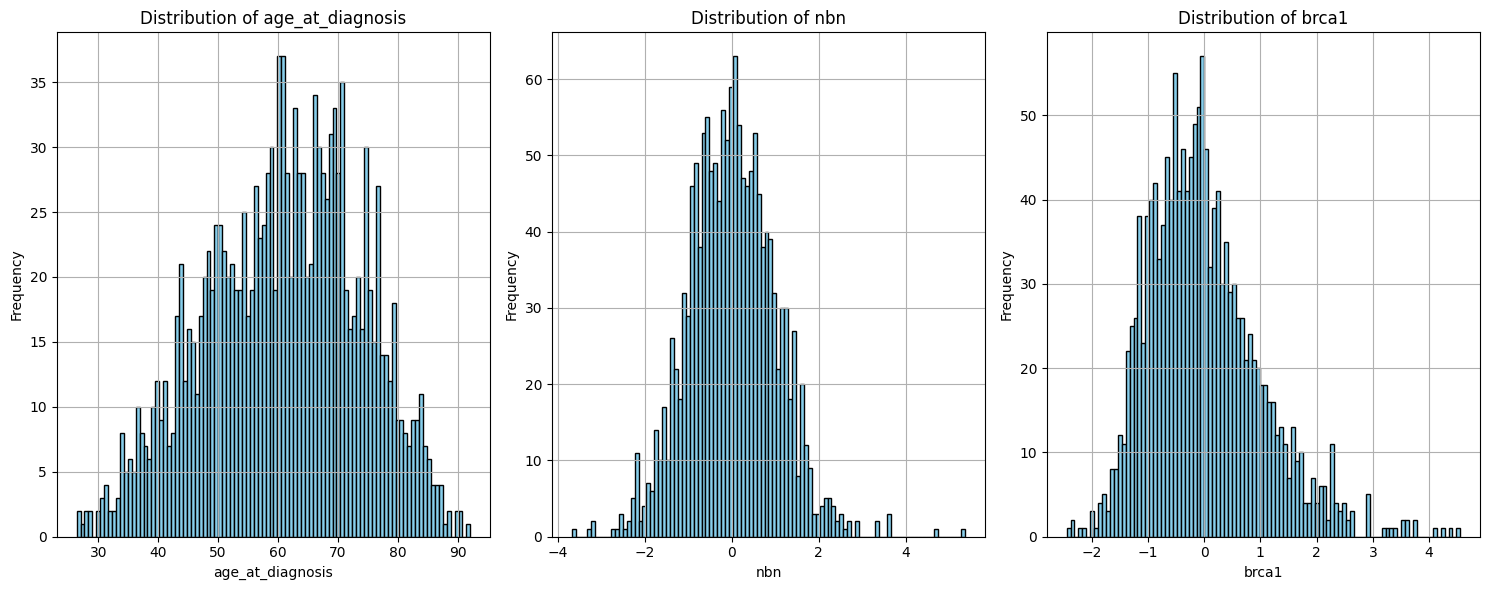

In [5]:
### plotting distribution of some columns
data = pd.read_csv("data.csv")
columns = ['age_at_diagnosis','nbn','brca1']
num_plots = len(columns)
fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(15, 6))

for i, column in enumerate(columns):
    axes[i].hist(data[column], bins=100, color='skyblue', edgecolor='black')
    axes[i].set_title('Distribution of ' + column)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [7]:
data = pd.read_csv("data.csv")
data_train = pre_process(data.drop("cancer_type",axis=1))
data_labels = encode_labels(data)
X_train,X_temp,y_train,y_temp = train_test_split(data_train,data_labels,test_size=0.25,random_state=42,stratify=data_labels)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42,stratify=y_temp)

svm = SVC(random_state=42)

# Define a grid of hyperparameters
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Setup the grid search
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Best model
best_svm = grid_search.best_estimator_
# Predictions
y_pred = best_svm.predict(X_val)

# Evaluation
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.7914438502673797
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88       150
           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00         2
           3       0.50      0.14      0.22        14

    accuracy                           0.79       187
   macro avg       0.33      0.28      0.28       187
weighted avg       0.68      0.79      0.72       187



In [10]:
def apply_rfe(data, n_features_to_select=20):
    X = data.drop('cancer_type', axis=1)
    y = data['cancer_type']

    #### Splitting data into training and testing to avoid overfitting during feature selection
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    #### Initializing the base classifier
    classifier = RandomForestClassifier(n_estimators=20, random_state=42)

    #### Initializing RFE with the classifier
    rfe = RFE(estimator=classifier, n_features_to_select=n_features_to_select, step=1)
    rfe.fit(X_train, y_train)

    #### Printing the results
    print("Num Features: %s" % rfe.n_features_)
    print("Selected Features: %s" % list(X.columns[rfe.support_]))
    print("Feature Ranking: %s" % rfe.ranking_)

    return list(X.columns[rfe.support_])
  
def drop_remaining_columns(data, rfe):
    remaining_columns = [col for col in data.columns if col not in rfe]
    return data.drop(columns=remaining_columns)

# Optionally handle class imbalance
data = pd.read_csv("data.csv")
data_train = pre_process(data.drop("cancer_type", axis=1))
data_labels = encode_labels(data)
X_train, X_temp, y_train, y_temp = train_test_split(data_train, data_labels, test_size=0.25, random_state=42, stratify=data_labels)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

train_data = pd.concat([y_train, X_train], axis=1)
# train_data_oversampled = undersample_data(train_data)
train_data_oversampled = train_data
X_train_oversampled = train_data_oversampled.drop("cancer_type", axis=1)
y_train_oversampled = train_data_oversampled['cancer_type']

# Combine back into a DataFrame for easy handling
data_resampled = pd.concat([y_train_oversampled,X_train_oversampled], axis=1)

# Apply RFE
rfe_results = apply_rfe(data_resampled, n_features_to_select=300)

data_resampled_selected = drop_remaining_columns(data_resampled,rfe_results)

Num Features: 300
Selected Features: ['overall_survival_months', 'brca1', 'brca2', 'pten', 'tp53', 'atm', 'cdh1', 'chek2', 'nbn', 'nf1', 'bard1', 'mlh1', 'msh2', 'pms2', 'rad51c', 'rad51d', 'rad50', 'rbl1', 'cdk1', 'ccne1', 'cdc25a', 'ccnd1', 'cdk6', 'ccnd2', 'cdkn2a', 'cdkn2b', 'cdkn1a', 'cdkn1b', 'e2f2', 'e2f3', 'e2f4', 'e2f7', 'src', 'jak2', 'stat1', 'stat5a', 'mdm2', 'tp53bp1', 'adam10', 'aph1a', 'aph1b', 'ctbp1', 'cul1', 'dtx1', 'dtx2', 'dtx3', 'dtx4', 'ep300', 'fbxw7', 'hdac2', 'itch', 'lfng', 'maml2', 'maml3', 'ncor2', 'ncstn', 'notch1', 'notch2', 'notch3', 'rbpjl', 'rfng', 'spen', 'hes2', 'hes7', 'hey1', 'hey2', 'acvr2a', 'acvr2b', 'acvrl1', 'akt1s1', 'arl11', 'atr', 'aurka', 'bcl2', 'bmp10', 'bmp15', 'bmp3', 'bmp4', 'bmp5', 'bmp6', 'bmp7', 'bmpr1a', 'bmpr2', 'braf', 'casp10', 'casp6', 'casp7', 'casp8', 'chek1', 'csf1', 'csf1r', 'cxcl8', 'cxcr1', 'cxcr2', 'dab2', 'eif4e', 'eif4ebp1', 'eif5a2', 'erbb3', 'fgf1', 'folr2', 'foxo3', 'gdf2', 'gsk3b', 'hif1a', 'hla-g', 'hras', 'igf1',

Reloading Tuner from my_dir\keras_tuner_cv\tuner0.json


Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3859 - loss: 1.7139 - val_accuracy: 0.8342 - val_loss: 0.6084
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5107 - loss: 1.3276 - val_accuracy: 0.8289 - val_loss: 0.6135
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5776 - loss: 1.1073 - val_accuracy: 0.8289 - val_loss: 0.6129
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6242 - loss: 0.9610 - val_accuracy: 0.8182 - val_loss: 0.6155
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6703 - loss: 0.8951 - val_accuracy: 0.8235 - val_loss: 0.6277
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6958 - loss: 0.7952 - val_accuracy: 0.8128 - val_loss: 0.6347
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7411 - loss: 0.6863 - val_accuracy: 0.7968 - val_loss: 0.6325
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7456 - loss: 0.6780 - val_accuracy: 0.7914 - val_loss:

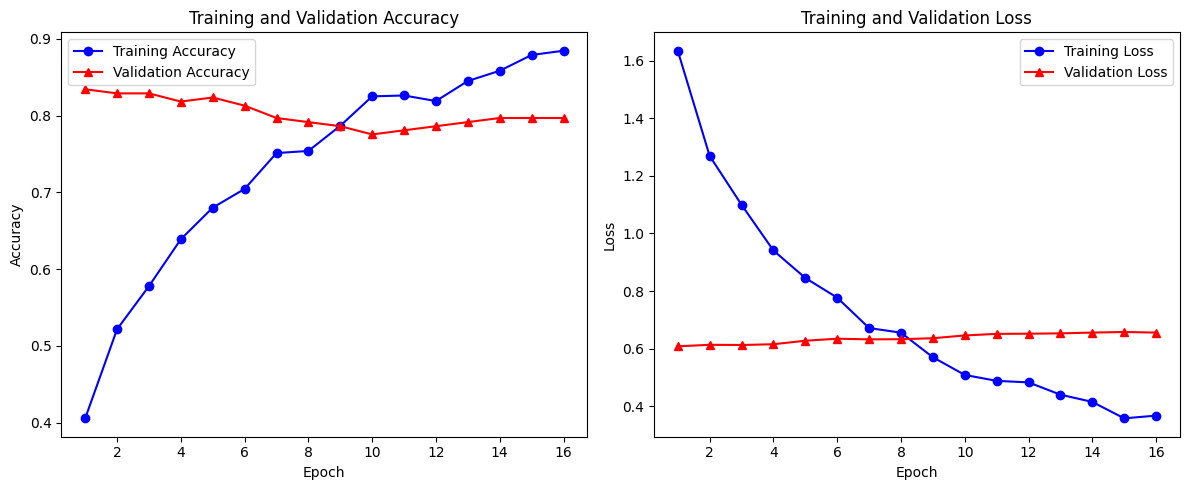

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Test F1 Score: 0.8288770053475936


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score,classification_report
from tensorflow.keras.callbacks import EarlyStopping


data = pd.read_csv("data.csv")
data_train = pre_process(data.drop("cancer_type", axis=1))
data_labels = encode_labels(data)

X_train, X_temp, y_train, y_temp = train_test_split(data_train, data_labels, test_size=0.25, random_state=42, stratify=data_labels)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
train_data = pd.concat([y_train, X_train], axis=1)
train_data_oversampled = undersample_data(train_data)
X_train_oversampled = train_data_oversampled.drop("cancer_type", axis=1)
y_train_oversampled = train_data_oversampled['cancer_type']

def build_model(hp):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(hp.Int('units', min_value=64, max_value=256, step=32), activation='relu', kernel_regularizer=l2(hp.Float('l2', min_value=1e-4, max_value=1e-2, sampling='log'))),
        BatchNormalization(),
        Dropout(hp.Float('dropout', min_value=0.3, max_value=0.9, step=0.1)),
        Dense(hp.Int('units', min_value=64, max_value=256, step=32), activation='relu', kernel_regularizer=l2(hp.Float('l2', min_value=1e-4, max_value=1e-2, sampling='log'))),
        BatchNormalization(),
        Dropout(hp.Float('dropout', min_value=0.3, max_value=0.9, step=0.1)),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming the presence of valid train, validation, and test sets
tuner = kt.RandomSearch(build_model, objective='val_accuracy', max_trials=10, executions_per_trial=1, directory='my_dir', project_name='keras_tuner_cv')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

tuner.search(X_train_oversampled, y_train_oversampled, epochs=30, validation_data=(X_val, y_val), callbacks=[early_stopping])

best_model = tuner.get_best_models(num_models=1)[0]
best_model.save("best_model.h5")
history = best_model.fit(X_train_oversampled, y_train_oversampled, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])
plot_learning_curves(history)

# Evaluate the model
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
test_f1_score = f1_score(y_test, y_pred_classes, average='micro')
print("Test F1 Score:", test_f1_score)